In [92]:
"""
The code in this file is part of the instructor-provided template for Assignment-1, task-2, Fall 2021. 
"""

import pycuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import numpy as np
import pycuda.driver as cuda
import pycuda.gpuarray as gpuarray
import math
import time
import matplotlib.pyplot as plt
%matplotlib inline


class deviceAdd:
    def __init__(self):
        """
        Attributes for instance of deviceAdd module
        Includes kernel code and input variables.
        """

        # Compile the kernel code when an instance
        # of this class is made. This way it only
        # needs to be done once for the 3 functions
        # you will call from this class.
        self.mod = self.getSourceModule()
        # Call the kernel function from the compiled module
        self.func_AddV = self.mod.get_function("AddVector")
        # Get grid and block dim
        self.blocksize = 256

    def getSourceModule(self):
        """
        Compiles Kernel in Source Module to be used by functions across the class.
        """
        # define your kernel below.
        kernelwrapper = """
        __global__
        void AddVector(float *a, float *b, float *c, int length){
            int i = blockIdx.x*blockDim.x + threadIdx.x;
            if(i<length) c[i] = a[i]+b[i];
        }

        """
        return SourceModule(kernelwrapper)

    
    def explicitAdd(self, a, b, length):
        """
        Function to perform on-device parallel vector addition
        by explicitly allocating device memory for host variables.
        Arguments:
            a                               :   numpy array of size: length
            b                               :   numpy array of size: length
            length                          :   length of numpy arrays 
        Returns
            c                               :   addition result
            time_alc                        :   execution time with memory allocation
            time_cpt                        :   execution time without memory allocation
        """

        # Event objects to mark the start and end points
        start_alc = cuda.Event()
        start_cpt = cuda.Event()
        end = cuda.Event()

        # Device memory allocation for input and output arrays
            # a_d, b_d, c_d are arrays in the device
            # a, b, c are the arrays in the host
            # create c in host
        c = np.empty_like(a)
            # record from allocation
        start_alc.record()
            # allocate space in the device
        a_d = cuda.mem_alloc(a.size*a.dtype.itemsize)
        b_d = cuda.mem_alloc(b.size*b.dtype.itemsize)
        c_d = cuda.mem_alloc(c.size*c.dtype.itemsize)
        # print(c_d)

        # Copy data from host to device
        cuda.memcpy_htod(a_d, a)
        cuda.memcpy_htod(b_d,b)

        # Call the kernel function from the compiled module
           # get function from Cuda C code


        # Get grid and block dim
        blockdim = (self.blocksize,1,1)
        griddim = (math.ceil(length/self.blocksize),1,1)
        
        # Record execution time and call the kernel loaded to the device
        start_cpt.record()  # recording the time consumed
        self.func_AddV(a_d, b_d, c_d, np.int32(length), block=blockdim, grid=griddim)

        # Wait for the event to complete
        end.record()
            # synchronize for recording time is necessary, cause recording is asynchronize
        end.synchronize()
        time_alc = start_alc.time_till(end)
        time_cpt = start_cpt.time_till(end)
        # print(time)

        # Copy result from device to the host
        cuda.memcpy_dtoh(c, c_d)

        # return a tuple of output of addition and time taken to execute the operation.
        return (c, time_alc, time_cpt)

    
    def implicitAdd(self, a, b, length):
        """
        Function to perform on-device parallel vector addition
        without explicitly allocating device memory for 
        host variables.
        Arguments:
            a                               :   numpy array of size: length
            b                               :   numpy array of size: length
            length                          :   length of numpy arrays 
        Returns
            c                               :   addition result
            time                            :   execution time
        """
        # Event objects to mark the start and end points
        start = cuda.Event()
        end = cuda.Event()

        # Get grid and block dim
        blockdim = (self.blocksize,1,1)
        griddim = (math.ceil(length/self.blocksize),1,1)

        # Call the kernel function from the compiled module
        # func_AddV = self.mod.get_function("AddVector")

        # Record execution time and call the kernel loaded to the device
        start.record()
        c = np.empty_like(a)
        self.func_AddV(cuda.In(a), cuda.In(b), cuda.Out(c), np.int32(length), block=blockdim, grid=griddim)

        # Wait for the event to complete
        end.record()
        end.synchronize()
        time = start.time_till(end)

        # return a tuple of output of addition and time taken to execute the operation.
        return c, time


    def gpuarrayAdd_np(self, a, b):
        """
        Function to perform on-device parallel vector addition
        without explicitly allocating device memory for 
        host variables and WITHOUT calling the kernel. The operation
        is defined using numpy-like syntax. 
        Arguments:
            a                               :   numpy array of size: length
            b                               :   numpy array of size: length
            //length                          :   length of numpy arrays 
        Returns
            c                               :   addition result
            time_alc                        :   execution time with memory allocation
            time_cpt                        :   execution time without memory allocation
        """
        # Event objects to mark start and end points
        start_alc = cuda.Event()
        start_cpt = cuda.Event()
        end = cuda.Event()

        # Allocate device memory using gpuarray class
        start_alc.record()        
        a_d = gpuarray.to_gpu(a)
        b_d = gpuarray.to_gpu(b)
    
        # Record execution time and execute operation with numpy syntax
        start_cpt.record()
        c_d = a_d + b_d
        end.record()

        # Wait for the event to complete
        end.synchronize()
        time_alc = start_alc.time_till(end)
        time_cpt = start_cpt.time_till(end)

        # Fetch result from device to host
        c = np.empty_like(a)
        c = c_d.get()

        # return a tuple of output of addition and time taken to execute the operation.
        return c, time_alc, time_cpt
        
    def gpuarrayAdd(self, a, b, length):
        """
        Function to perform on-device parallel vector addition
        without explicitly allocating device memory for 
        host variables and WITHOUT calling the kernel. The operation
        is defined using numpy-like syntax. 
        Arguments:
            a                               :   numpy array of size: length
            b                               :   numpy array of size: length
            length                          :   length of numpy arrays 
        Returns
            c                               :   addition result
            time_alc                        :   execution time with memory allocation
            time_cpt                        :   execution time without memory allocation
        """

        # Create cuda events to mark the start and end of array.
        start_alc = cuda.Event()
        start_cpt = cuda.Event()
        end = cuda.Event()

        # Get function defined in class defination
         

        # Allocate device memory for a, b, output of addition using gpuarray class        
        c = np.empty_like(a)
        start_alc.record()        
        a_d = gpuarray.to_gpu(a)
        b_d = gpuarray.to_gpu(b)
        c_d = gpuarray.to_gpu(c)

        # Get grid and block dim
        blockdim = (self.blocksize,1,1)
        griddim = (math.ceil(length/self.blocksize),1,1)

        # Record execution time and execute operation with numpy syntax (for recording execution time use cuda event start)
        start_cpt.record()
        self.func_AddV(a_d, b_d, c_d, np.int32(length), block=blockdim, grid=griddim)
        end.record()

        # Wait for the event to complete
        end.synchronize()
        time_alc = start_alc.time_till(end)
        time_cpt = start_cpt.time_till(end)

        # Fetch result from device to host
        c = c_d.get()

        # return a tuple of output of addition and time taken to execute the operation.
        return c, time_alc, time_cpt

    def numpyAdd(self, a, b):
        """
        Function to perform on-host vector addition. The operation
        is defined using numpy-like syntax. 
        Returns (addition result, execution time)
        """
        # Initialize empty array on host to store result
        start = time.time()
        c = np.add(a, b)
        end = time.time()
        
        return c, end - start



In [93]:
def average_time(method_name, N=1024, iteration=10):
    """
    Function to compute the average time comsumed by addtional functions
    Arguments:
        N           :   length of vectors
        iteration   :   number of iterations of one specific function
        method_name :   the name of the function
    """
    # used to record the processing time
    time_alc = 0
    time_cpt = 0
    # make an instance of the clModule class
    adop = deviceAdd()
    # using method of explicit allocation
    if method_name == 'explicit':
        for i in range(iteration):
            a = np.random.rand(N).astype(np.float32)
            b = np.random.rand(N).astype(np.float32)
            _, temp_alc, temp_cpt = adop.explicitAdd(a,b,N)
            time_alc += temp_alc
            time_cpt += temp_cpt
        time_alc /= iteration
        time_cpt /= iteration
        return time_alc, time_cpt
    # using method of implicit allocation
    elif method_name == 'implicit':
        for i in range(iteration):
            a = np.random.rand(N).astype(np.float32)
            b = np.random.rand(N).astype(np.float32)
            _, temp_alc = adop.implicitAdd(a,b,N)
            time_alc += temp_alc
        time_alc /= iteration
        return time_alc, None
    # using method of gpuarray with numpy syntax
    elif method_name == 'gpuarraynp':
        for i in range(iteration):
            a = np.random.rand(N).astype(np.float32)
            b = np.random.rand(N).astype(np.float32)
            _, temp_alc, temp_cpt = adop.gpuarrayAdd_np(a,b)
            time_alc += temp_alc
            time_cpt += temp_cpt
        time_alc /= iteration
        time_cpt /= iteration
        return time_alc, time_cpt
    # using method of gpuarray with kernel
    elif method_name == 'gpuarray':
        for i in range(iteration):
            a = np.random.rand(N).astype(np.float32)
            b = np.random.rand(N).astype(np.float32)
            _, temp_alc, temp_cpt = adop.gpuarrayAdd(a,b,N)
            time_alc += temp_alc
            time_cpt += temp_cpt
        time_alc /= iteration
        time_cpt /= iteration
        return time_alc, time_cpt
    # using numpy in the host
    elif method_name == 'host':
        for i in range(iteration):
            a = np.random.rand(N).astype(np.float32)
            b = np.random.rand(N).astype(np.float32)
            _, temp_alc = adop.numpyAdd(a,b)
            time_alc += temp_alc
        time_alc /= iteration
        return time_alc, None
    else:
        print('No such method name!')


if __name__ == "__main__":
    # Define the number of iterations and starting lengths of vectors
    N = 1024
    iteration = 1
    
    # Create an instance of the deviceAdd class
    # adop = deviceAdd()
    # a = np.random.rand(N).astype(np.float32)
    # b = np.random.rand(N).astype(np.float32)
    # c, time_alc, time_cpt = adop.explicitAdd(a,b,N)
    # print(c, time_alc, time_cpt)

    # Perform addition tests for increasing lengths of vectors
    # L = 10, 100, 1000 ..., (You can use np.random.randn to generate two vectors)
    L = []
    for i in range(8): L.append(10**(i+1))

    time_explicit_alc = []
    time_explicit_cpt = []

    time_implicit_alc = []   
    time_implicit_cpt = []

    time_gpuarynp = []

    time_gpuary_alc = []
    time_gpuary_cpt = []

    time_host = []

    for l in L:
        time_alc, time_cpt = average_time('explicit', N=l, iteration=iteration)
        time_explicit_alc.append(time_alc)
        time_explicit_cpt.append(time_cpt)

        time_alc,_ = average_time('implicit', N=l, iteration=iteration)
        time_implicit_alc.append(time_alc)
        time_implicit_cpt.append(time_cpt)

        time_alc, time_cpt = average_time('gpuarraynp', N=l, iteration=iteration)
        time_gpuarynp.append(time_alc)

        time_alc, time_cpt = average_time('gpuarray', N=l, iteration=iteration)
        time_gpuary_alc.append(time_alc)
        time_gpuary_cpt.append(time_cpt)

        time_alc,_ = average_time('host', N=l, iteration=iteration)
        time_host.append(time_alc)





    # Compare outputs.

    # Plot the compute times

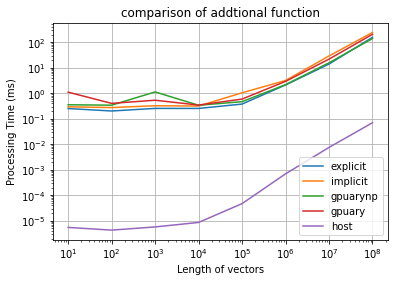

In [94]:
def plotting(time_explicit, time_implicit, time_gpuarynp, time_gpuary, time_host, L):
    plt.figure()
    plt.plot(L,time_explicit,label='explicit')
    plt.plot(L,time_implicit,label='implicit')
    plt.plot(L,time_gpuarynp,label='gpuarynp')
    plt.plot(L,time_gpuary,label='gpuary')
    plt.plot(L,time_host,label='host')
    plt.semilogx()
    plt.semilogy()
    plt.legend()
    plt.grid()
    plt.xlabel('Length of vectors')
    plt.ylabel('Processing Time (ms)')
    plt.title('comparison of addtional function')
    plt.show()


plotting(time_explicit_alc, time_implicit_alc, time_gpuarynp, time_gpuary_alc, time_host, L)

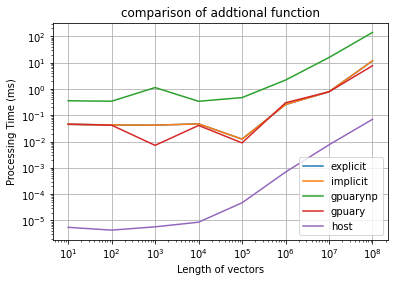

In [95]:
plotting(time_explicit_cpt, time_implicit_cpt, time_gpuarynp, time_gpuary_cpt, time_host, L)